## Daisy's Test/Train Code


In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
# Set path to local data directory
folder_path = "/Users/ellajones/Downloads/Optiver_additional data"

# Define file paths
feature_path = os.path.join(folder_path, "order_book_feature.parquet")
target_path = os.path.join(folder_path, "order_book_target.parquet")

# Load parquet files (first 30 mins = feature, last 30 mins = target side of the hour)
feature_df = pd.read_parquet(feature_path, engine='pyarrow')
target_df = pd.read_parquet(target_path, engine='pyarrow')

# Concatenating both DataFrames vertically (stacking feature + target rows)
# Note: This doesn't align features and targets — it's just combining both halves of the hour
combined_df = pd.concat([feature_df, target_df], axis=0)

# Sort to organize by stock, time, and within-hour time buckets
combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)


Feature DF: (17646119, 11)
Target DF: (17911332, 11)

Feature columns: ['stock_id', 'time_id', 'seconds_in_bucket', 'bid_price1', 'ask_price1', 'bid_price2', 'ask_price2', 'bid_size1', 'ask_size1', 'bid_size2', 'ask_size2']

Target columns: ['stock_id', 'time_id', 'seconds_in_bucket', 'bid_price1', 'ask_price1', 'bid_price2', 'ask_price2', 'bid_size1', 'ask_size1', 'bid_size2', 'ask_size2']

Concat DF (head):


,stock_id,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,8382,6,1800.0,740.03,740.29,740.0,740.30,6,6,800,40
1,8382,6,1800.0,740.03,740.29,740.0,740.30,6,6,800,40
2,8382,6,1801.0,740.05,740.29,740.0,740.30,25,1,99,40
3,8382,6,1801.0,740.05,740.29,740.0,740.30,25,1,99,40
4,8382,6,1802.0,740.06,740.36,740.0,740.39,100,30,399,4



Concat DF (tail):


,stock_id,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
35557446,104919,1199,3595.0,362.73,362.74,362.72,362.75,200,1190,1200,1600
35557447,104919,1199,3596.0,362.68,362.70,362.67,362.71,800,200,1600,1400
35557448,104919,1199,3597.0,362.69,362.70,362.68,362.71,200,900,1400,1400
35557449,104919,1199,3598.0,362.72,362.73,362.71,362.74,200,1000,900,500
35557450,104919,1199,3599.0,362.80,362.81,362.79,362.82,200,300,600,300


In [3]:
# Apply feature engineering function to the combined DataFrame (includes both first + last 30 min)
def compute_orderbook_features(df):
    """
    Compute engineered order book features from raw order book snapshots.
    """
    df = df.copy()

    # Mid price and Weighted Average Price
    df['mid_price'] = (df['bid_price1'] + df['ask_price1']) / 2
    df['wap'] = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (
        df['bid_size1'] + df['ask_size1']
    )

    # Spread and relative spread
    df['bid_ask_spread'] = df['ask_price1'] - df['bid_price1']
    df['spread_pct'] = df['bid_ask_spread'] / df['mid_price']

    # Spread variation over time within the same time_id
    df['spread_variation'] = df.groupby(['stock_id', 'time_id'])['spread_pct'].transform(
        lambda x: x.rolling(window=10, min_periods=1).std()
    )

    # Order book imbalance and depth ratio
    df['imbalance'] = (df['bid_size1'] - df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    df['depth_ratio'] = df['bid_size1'] / df['ask_size1'].replace(0, np.nan)

    # Return only the engineered features
    keep_cols = [
        'stock_id', 'time_id', 'seconds_in_bucket',
        'wap', 'spread_pct', 'imbalance', 'depth_ratio', 'spread_variation'
    ]
    return df[keep_cols]

# Apply feature engineering to the combined order book data
feature_engineered_df = compute_orderbook_features(combined_df)

# Preview result
feature_engineered_df.head()

,stock_id,time_id,seconds_in_bucket,wap,spread_pct,imbalance,depth_ratio,spread_variation
0,8382,6,1800.0,740.160000,0.000351,0.000000,1.000000,NaN
1,8382,6,1800.0,740.160000,0.000351,0.000000,1.000000,0.000000
2,8382,6,1801.0,740.280769,0.000324,0.923077,25.000000,0.000016
3,8382,6,1801.0,740.280769,0.000324,0.923077,25.000000,0.000016
4,8382,6,1802.0,740.290769,0.000405,0.538462,3.333333,0.000033


In [4]:
time_ref_path = os.path.join(folder_path, "time_id_reference.csv")
time_ref_df = pd.read_csv(time_ref_path)
time_ref_df.head()

,date,time,time_id
0,2021-01-05,11:00:00,12
1,2021-01-05,12:00:00,13
2,2021-01-05,13:00:00,14
3,2021-01-05,14:00:00,15
4,2021-01-05,15:00:00,16


In [5]:
time_ref_df["datetime"] = pd.to_datetime(time_ref_df["date"] + " " + time_ref_df["time"])
time_ref_df.head()

,date,time,time_id,datetime
0,2021-01-05,11:00:00,12,2021-01-05 11:00:00
1,2021-01-05,12:00:00,13,2021-01-05 12:00:00
2,2021-01-05,13:00:00,14,2021-01-05 13:00:00
3,2021-01-05,14:00:00,15,2021-01-05 14:00:00
4,2021-01-05,15:00:00,16,2021-01-05 15:00:00


In [6]:
# Re-do the merge and keep only the new datetime column
feature_engineered_df = pd.merge(
    feature_engineered_df.drop(columns=["datetime"], errors="ignore"),  # just in case it already exists
    time_ref_df[["time_id", "datetime"]],
    on="time_id",
    how="left"
)
feature_engineered_df.head()
feature_engineered_df.tail()

,stock_id,time_id,seconds_in_bucket,wap,spread_pct,imbalance,depth_ratio,spread_variation,datetime
35557446,104919,1199,3595.0,362.731439,0.000028,-0.712230,0.168067,0.000012,2021-10-07 16:00:00
35557447,104919,1199,3596.0,362.696000,0.000055,0.600000,4.000000,0.000012,2021-10-07 16:00:00
35557448,104919,1199,3597.0,362.691818,0.000028,-0.636364,0.222222,0.000012,2021-10-07 16:00:00
35557449,104919,1199,3598.0,362.721667,0.000028,-0.666667,0.200000,0.000012,2021-10-07 16:00:00
35557450,104919,1199,3599.0,362.804000,0.000028,-0.200000,0.666667,0.000012,2021-10-07 16:00:00


In [7]:
# Sort just in case
feature_engineered_df = feature_engineered_df.sort_values(by="time_id")

# Unique time_ids
unique_ids = sorted(feature_engineered_df["time_id"].unique())
cutoff = int(len(unique_ids) * 0.8)

# Train on earliest 80%, test on latest 20%
train_ids = unique_ids[:cutoff]
test_ids = unique_ids[cutoff:]

train_df_timeid = feature_engineered_df[feature_engineered_df["time_id"].isin(train_ids)]
test_df_timeid = feature_engineered_df[feature_engineered_df["time_id"].isin(test_ids)]

print("TimeID Split:")
print("Train shape:", train_df_timeid.shape)
print("Test shape:", test_df_timeid.shape)

TimeID Split:
Train shape: (28513833, 9)
Test shape: (7043618, 9)


In [8]:
qqq_df = feature_engineered_df[feature_engineered_df["stock_id"] == 104919].copy()
qqq_df["date_only"] = qqq_df["datetime"].dt.date

qqq_df.head()

,stock_id,time_id,seconds_in_bucket,wap,spread_pct,imbalance,depth_ratio,spread_variation,datetime,date_only
31393488,104919,6,2992.0,312.299875,0.000032,0.975000,79.000000,0.000017,NaT,NaT
31393489,104919,6,2993.0,312.262896,0.000064,-0.710446,0.169286,0.000017,NaT,NaT
31393490,104919,6,2993.0,312.262896,0.000064,-0.710446,0.169286,0.000017,NaT,NaT
31393491,104919,6,2994.0,312.280598,0.000064,-0.940178,0.030833,0.000017,NaT,NaT
31393492,104919,6,2994.0,312.280598,0.000064,-0.940178,0.030833,0.000017,NaT,NaT


In [9]:
#  Compute log returns (per time_id)
qqq_df["log_return"] = qqq_df.groupby("time_id")["wap"].transform(lambda x: np.log(x / x.shift(1)))

# Compute realized volatility per time_id
rv_df = qqq_df.groupby("time_id")["log_return"].agg(lambda x: np.sqrt(np.sum(x**2))).reset_index()

rv_df = rv_df.rename(columns={"log_return": "realized_volatility"})

#  Merge back into qqq_df
qqq_df = pd.merge(qqq_df, rv_df, on="time_id", how="left")

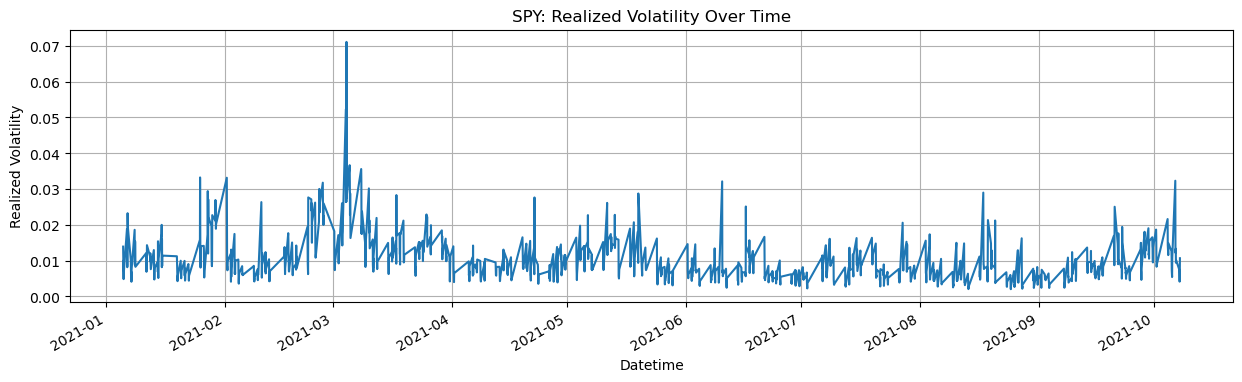

In [10]:
# Plot volatility over time
qqq_df.groupby("datetime")["realized_volatility"].mean().plot(
    figsize=(15, 4), title="QQQ: Realized Volatility Over Time"
)
plt.xlabel("Datetime")
plt.ylabel("Realized Volatility")
plt.grid(True)
plt.show()

# XGBOOST

## Using 80/20 split on time_id for test/training data

In [11]:
xgb_df = qqq_df.copy()

,stock_id,time_id,seconds_in_bucket,wap,spread_pct,imbalance,depth_ratio,spread_variation,datetime,date_only,log_return,realized_volatility
0,104919,6,2992.0,312.299875,0.000032,0.975000,79.000000,1.653858e-05,NaT,NaT,NaN,0.01906
1,104919,6,2993.0,312.262896,0.000064,-0.710446,0.169286,1.653893e-05,NaT,NaT,-0.000118,0.01906
2,104919,6,2993.0,312.262896,0.000064,-0.710446,0.169286,1.653928e-05,NaT,NaT,0.000000,0.01906
3,104919,6,2994.0,312.280598,0.000064,-0.940178,0.030833,1.653858e-05,NaT,NaT,0.000057,0.01906
4,104919,6,2994.0,312.280598,0.000064,-0.940178,0.030833,1.653787e-05,NaT,NaT,0.000000,0.01906
5,104919,6,2995.0,312.291577,0.000064,-0.842257,0.085625,1.653717e-05,NaT,NaT,0.000035,0.01906
6,104919,6,2995.0,312.291577,0.000064,-0.842257,0.085625,1.653646e-05,NaT,NaT,0.000000,0.01906
7,104919,6,2996.0,312.310000,0.000064,0.000000,1.000000,1.546811e-05,NaT,NaT,0.000059,0.01906
8,104919,6,2996.0,312.310000,0.000064,0.000000,1.000000,1.350146e-05,NaT,NaT,0.000000,0.01906
9,104919,6,2997.0,312.396667,0.000064,-0.333333,0.500000,1.012532e-05,NaT,NaT,0.000277,0.01906


In [12]:
features_to_lag = ["realized_volatility", "wap", "imbalance", "spread_variation", "spread_pct", "depth_ratio", "log_return"]

for feature in features_to_lag:
    for lag in [1, 5, 10]:
        xgb_df[f"{feature}_lag_{lag}"] = xgb_df[feature].shift(lag)

xgb_df = xgb_df.dropna().reset_index(drop=True)

In [40]:
current_features = ["wap", "spread_pct", "imbalance", "depth_ratio", "spread_variation", "log_return"]
lagged_features = [col for col in xgb_df.columns if 'lag' in col]

feature_columns = current_features + lagged_features

In [82]:
X = xgb_df[feature_columns]
y = xgb_df["realized_volatility"]

cutoff = int(len(xgb_df) * 0.8)

X_train = X.iloc[:cutoff]
y_train = y.iloc[:cutoff]
X_test = X.iloc[cutoff:]
y_test = y.iloc[cutoff:]

In [23]:
from xgboost import XGBRegressor

In [44]:
xgb_model = XGBRegressor(
    n_estimators=100, #number of decision tress
    max_depth=4, #limits how complex each tree can be - avoids overfitting
    learning_rate=0.1, #how much each tree "corrects" the model
    objective='reg:squarederror', #goal is to predict continuous number
    random_state=42 # fixes randomness for repeatability
)

In [83]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [84]:
y_pred = xgb_model.predict(X_test)

In [67]:
y_test.head()

3308505    0.002056
3308506    0.002056
3308507    0.002056
3308508    0.002056
3308509    0.002056
Name: realized_volatility, dtype: float64

### Performance Metrics

In [50]:
from sklearn.metrics import mean_squared_error

In [54]:
def qlike(y_true, y_pred):
    return np.mean(np.log(y_pred) + (y_true / y_pred))

In [86]:
mse = mean_squared_error(y_test, y_pred)
qlikel = qlike(y_test.values, y_pred)

print(f"MSE: {mse:.12f}")
print(f"QLIKE: {qlikel:.6f}")

MSE: 0.000000005301
QLIKE: -3.926503


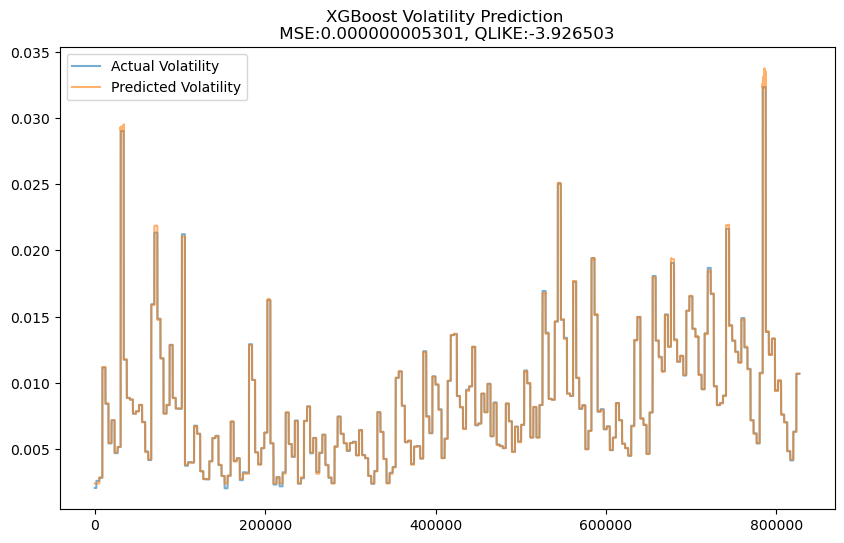

In [87]:
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual Volatility", alpha=0.6)
plt.plot(y_pred, label="Predicted Volatility", alpha=0.6)
plt.legend()
plt.title(f"QQQ: XGBoost Volatility Prediction \n MSE:{mse:.12f}, QLIKE:{qlikel:.6f} ")
plt.show()

## Final Version - aggregating data for each time id. 

In [72]:
agg_df = xgb_df.groupby("time_id")["realized_volatility"].mean().reset_index()

In [73]:
X = agg_df.drop(columns=["time_id", "realized_volatility"])  # all features except time_id and target
y = agg_df["realized_volatility"]

In [74]:
agg_df = xgb_df.groupby("time_id").agg({
    "realized_volatility": "mean",
    "wap": "mean",  
    "spread_pct": "mean",
    "imbalance": "mean",
    "depth_ratio": "mean",
    "spread_variation": "mean",
    "log_return": "mean",
}).reset_index()

# Now select features and target
X = agg_df.drop(columns=["time_id", "realized_volatility"])
y = agg_df["realized_volatility"]

In [75]:
cutoff = int(len(agg_df) * 0.8)

X_train = X.iloc[:cutoff]
y_train = y.iloc[:cutoff]
X_test = X.iloc[cutoff:]
y_test = y.iloc[cutoff:]

In [76]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [77]:
y_pred = xgb_model.predict(X_test)

In [79]:
mse = mean_squared_error(y_test, y_pred)
qlikel = qlike(y_test.values, y_pred)

print(f"MSE: {mse:.12f}")
print(f"QLIKE: {qlikel:.6f}")

MSE: 0.000014635606
QLIKE: -3.820104


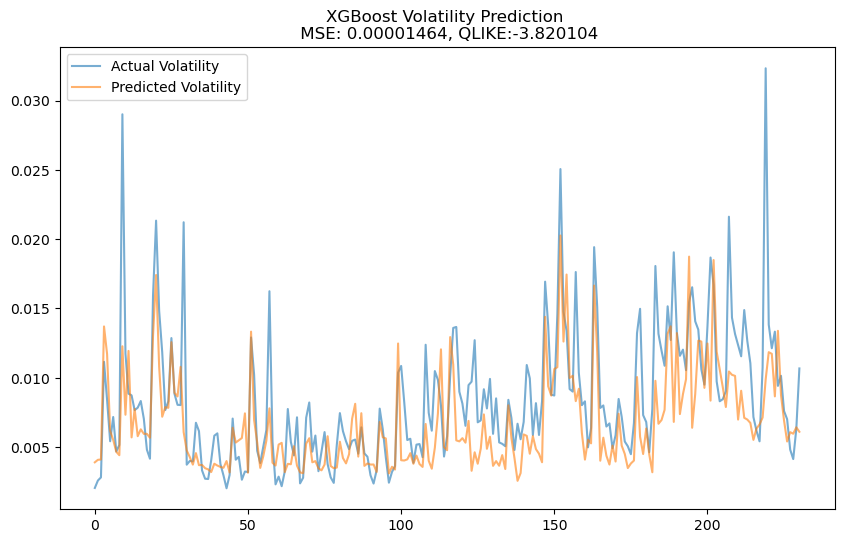

In [81]:
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual Volatility", alpha=0.6)
plt.plot(y_pred, label="Predicted Volatility", alpha=0.6)
plt.legend()
plt.title(f"XGBoost Volatility Prediction \n MSE: {mse:.8f}, QLIKE:{qlikel:.6f}")
plt.show()